In [16]:
import argparse, os, sys, glob
from collections import defaultdict
from ast import parse
import cv2
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext
import matplotlib.pyplot as plt

from structured_stable_diffusion.util import instantiate_from_config
from structured_stable_diffusion.models.diffusion.ddim import DDIMSampler
from structured_stable_diffusion.models.diffusion.plms import PLMSSampler


import stanza
from nltk.tree import Tree
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')
import pdb
import json
import sng_parser



def preprocess_prompts(prompts):
    if isinstance(prompts, (list, tuple)):
        return [p.lower().strip().strip(".").strip() for p in prompts]
    elif isinstance(prompts, str):
        return prompts.lower().strip().strip(".").strip()
    else:
        raise NotImplementedError


def get_all_nps(tree, full_sent=None):
    start = 0
    end = len(tree.leaves())

    def get_sub_nps(tree, left, right):
        if isinstance(tree, str) or len(tree.leaves()) == 1:
            return []
        sub_nps = []
        n_leaves = len(tree.leaves())
        n_subtree_leaves = [len(t.leaves()) for t in tree]
        offset = np.cumsum([0] + n_subtree_leaves)[:len(n_subtree_leaves)]
        assert right - left == n_leaves
        if tree.label() == 'NP' and n_leaves > 1:
            sub_nps.append([" ".join(tree.leaves()), (int(left), int(right))])
        for i, subtree in enumerate(tree):
            sub_nps += get_sub_nps(subtree, left=left+offset[i], right=left+offset[i]+n_subtree_leaves[i])
        return sub_nps
    
    all_nps = get_sub_nps(tree, left=start, right=end)
    lowest_nps = []
    for i in range(len(all_nps)):
        span = all_nps[i][1]
        lowest = True
        for j in range(len(all_nps)):
            span2 = all_nps[j][1]
            if span2[0] >= span[0] and span2[1] <= span[1]:
                lowest = False
                break
        if lowest:
            lowest_nps.append(all_nps[i])

    all_nps, spans = map(list, zip(*all_nps))
    if full_sent and full_sent not in all_nps:
        all_nps = [full_sent] + all_nps
        spans = [(start, end)] + spans

    return all_nps, spans, lowest_nps


def get_all_spans_from_scene_graph(caption):
    caption = caption.strip()
    graph = sng_parser.parse(caption)
    nps = []
    spans = []
    words = caption.split()
    for e in graph['entities']:
        start, end = e['span_bounds']
        if e['span'] == caption: continue
        if end-start == 1: continue
        nps.append(e['span'])
        spans.append(e['span_bounds'])
    for r in graph['relations']:
        start1, end1 = graph['entities'][r['subject']]['span_bounds']
        start2, end2 = graph['entities'][r['object']]['span_bounds']
        start = min(start1, start2)
        end = max(end1, end2)
        if " ".join(words[start:end]) == caption: continue
        nps.append(" ".join(words[start:end]))
        spans.append((start, end))
    
    return [caption] + nps, [(0, len(words))] + spans, None



def expand_sequence(seq, length, dim=1):
    seq = seq.transpose(0, dim)
    max_length = seq.size(0)
    n_repeat = (max_length - 2) // length
    repeat_size = (n_repeat,) + (1, ) * (len(seq.size()) -1)

    eos = seq[length+1, ...].clone()
    segment = seq[1:length+1, ...].repeat(*repeat_size)
    seq[1:len(segment)+1] = segment
    seq[len(segment)+1] = eos

    return seq.transpose(0, dim)


def align_sequence(main_seq, seq, span, eos_loc, dim=1, zero_out=False, replace_pad=False):
    seq = seq.transpose(0, dim)
    main_seq = main_seq.transpose(0, dim)
    start, end = span[0]+1, span[1]+1
    seg_length = end - start

    main_seq[start:end] = seq[1:1+seg_length]
    if zero_out:
        main_seq[1:start] = 0
        main_seq[end:eos_loc] = 0

    if replace_pad:
        pad_length = len(main_seq) - eos_loc
        main_seq[eos_loc:] = seq[1+seg_length:1+seg_length+pad_length]
    

    return main_seq.transpose(0, dim)


def get_actions(tree, SHIFT = 0, REDUCE = 1, OPEN='(', CLOSE=')'):
    #input tree in bracket form: ((A B) (C D))
    #output action sequence: S S R S S R R
    actions = []
    tree = tree.strip()
    i = 0
    num_shift = 0
    num_reduce = 0
    left = 0
    right = 0
    while i < len(tree):
        if tree[i] != ' ' and tree[i] != OPEN and tree[i] != CLOSE: #terminal
            if tree[i-1] == OPEN or tree[i-1] == ' ':
                actions.append(SHIFT)
                num_shift += 1
        elif tree[i] == CLOSE:
            actions.append(REDUCE)
            num_reduce += 1
            right += 1
        elif tree[i] == OPEN:
            left += 1
        i += 1
    pdb.set_trace()
    assert(num_shift == num_reduce + 1)
    return actions


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def load_replacement(x):
    try:
        hwc = x.shape
        y = Image.open("assets/rick.jpeg").convert("RGB").resize((hwc[1], hwc[0]))
        y = (np.array(y)/255.0).astype(x.dtype)
        assert y.shape == x.shape
        return y
    except Exception:
        return x

def sampling(model, sampler, prompt, n_samples, scale=7.5, steps=50, conjunction=False):
    H = W = 512
    C = 4
    f = 8
    precision_scope = autocast
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                all_samples = list()
                for n in trange(n_samples, desc="Sampling"):
                    for bid, p in enumerate(prompt):
                        p = preprocess_prompts(p)

                        uc = model.get_learned_conditioning([""])
                        if isinstance(p, tuple):
                            p = list(p)
                        c = model.get_learned_conditioning(p)
                        
                        doc = nlp(p[0])
                        mytree = Tree.fromstring(str(doc.sentences[0].constituency))
                        nps, spans, noun_chunk = get_all_nps(mytree, p[0])
                        # nps, spans, noun_chunk = get_all_spans_from_scene_graph(prompts[0].split("\t")[0])

                        nps_length = [len(ids)-2 for ids in model.cond_stage_model.tokenizer(nps).input_ids]
                        nps = [[np]*len(p) for np in nps]
                        
                        c = [model.get_learned_conditioning(np) for np in nps]
                        k_c = [c[0]] + [align_sequence(c[0].clone(), seq, span, nps_length[0]+1) for seq, span in zip(c[1:], spans[1:])]
                        v_c = [c[0]] + [align_sequence(c[0].clone(), seq, span, nps_length[0]+1) for seq, span in zip(c[1:], spans[1:])]
                        
                        if not conjunction:
                            c = {'k': k_c[:1], 'v': v_c}
                        else:
                            c = {'k': k_c, 'v': v_c[-1:]}

                        shape = [C, H // f, W // f]
                        samples_ddim, _ = sampler.sample(S=steps,
                                                            conditioning=c,
                                                            batch_size=1,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=scale,
                                                            unconditional_conditioning=uc,
                                                            eta=0.0,
                                                            x_T=None,
                                                            quiet=True)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
                        x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

                        x_checked_image = x_samples_ddim

                        x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)

                        all_samples.append(x_checked_image_torch)
    return all_samples


2022-11-15 12:11:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2022-11-15 12:11:07 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2022-11-15 12:11:07 INFO: Use device: gpu
2022-11-15 12:11:07 INFO: Loading: tokenize
2022-11-15 12:11:07 INFO: Loading: pos
2022-11-15 12:11:07 INFO: Loading: constituency
2022-11-15 12:11:08 INFO: Done loading processors!


In [7]:
ckpt = "../models/ldm/stable-diffusion-v1/model.ckpt"

config = OmegaConf.load("../configs/stable-diffusion/v1-inference.yaml")
model = load_model_from_config(config, f"{ckpt}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

sampler = PLMSSampler(model)

Loading model from ../models/ldm/stable-diffusion-v1/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm2.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.16.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_mod

In [38]:
prompt = [["a red car and a white sheep"]]
ddim_steps = 50
n_samples = 4
scale = 7.5

In [39]:
all_samples = sampling(model, sampler, prompt, 
                        n_samples, scale, 
                        ddim_steps, conjunction=True)

Sampling:   0%|          | 0/4 [00:00<?, ?it/s]

Running PLMS Sampling with 50 timesteps


Sampling:  25%|██▌       | 1/4 [00:05<00:17,  6.00s/it]

Running PLMS Sampling with 50 timesteps


Sampling:  50%|█████     | 2/4 [00:11<00:11,  5.99s/it]

Running PLMS Sampling with 50 timesteps


Sampling:  75%|███████▌  | 3/4 [00:17<00:05,  5.99s/it]

Running PLMS Sampling with 50 timesteps


Sampling: 100%|██████████| 4/4 [00:23<00:00,  5.99s/it]


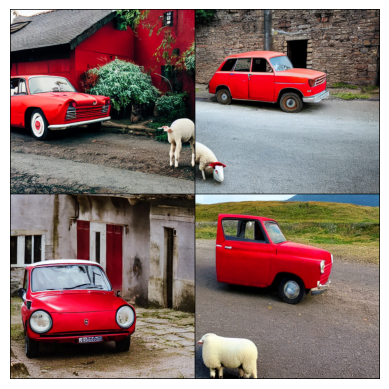

In [40]:
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=int(np.sqrt(n_samples)))

grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
img = Image.fromarray(grid.astype(np.uint8))
plt.imshow(img)
plt.axis("off")
plt.show()


In [43]:
prompt = [["a red teddy bear in a Christmas hat sitting \
            next to a glass, a can and a plastic cup full \
                of liquid, on a table in a living room"]]
all_samples = sampling(model, sampler, prompt, 
                        n_samples, scale, 
                        ddim_steps)

Sampling:   0%|          | 0/4 [00:00<?, ?it/s]

Running PLMS Sampling with 50 timesteps


Sampling:  25%|██▌       | 1/4 [00:06<00:19,  6.35s/it]

Running PLMS Sampling with 50 timesteps


Sampling:  50%|█████     | 2/4 [00:12<00:12,  6.36s/it]

Running PLMS Sampling with 50 timesteps


Sampling:  75%|███████▌  | 3/4 [00:19<00:06,  6.35s/it]

Running PLMS Sampling with 50 timesteps


Sampling: 100%|██████████| 4/4 [00:25<00:00,  6.35s/it]


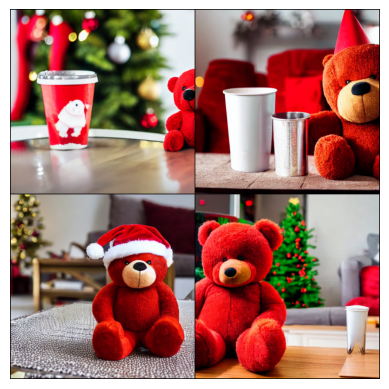

In [44]:
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=int(np.sqrt(n_samples)))

grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
img = Image.fromarray(grid.astype(np.uint8))
plt.imshow(img)
plt.axis("off")
plt.show()
